<a href="https://colab.research.google.com/github/Sairam-Bandarupalli/cs666student/blob/main/CS666_Assignment_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

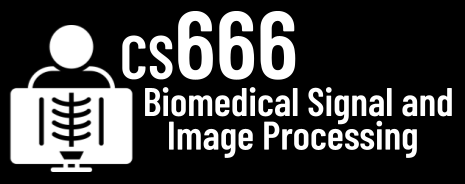
# Assignment 6

In [ ]:
# NAME: Sairam Bandarupalli

In [ ]:
# In this assignment, we will explore the new Segment-Anything-Model (https://segment-anything.com/)
# for the task of mitochondria detection in a connectomics dataset acquired using electron microscopy.
#
# We will run the following experiments:
#
# 1. Using the Segment-Anything-Model (SAM) without seeds in auto mode
#
# 2. Train a U-Net classifier from scratch
#
# 3. Evaluate the U-Net classifier
#
# 4. Use the U-Net to seed the SAM model (U-Net + SAM)
#
# 5. Compare U-Net vs. U-Net + SAM
#
# Bonus: Improve U-Net + SAM

In [ ]:
### IMPORTANT (DO THIS RIGHT AWAY!) ###
#
# Activate GPU support: Runtime -> Change Runtime Type
# Hardware Accelerator: GPU
#
### IMPORTANT ###

In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
# We will use mahotas as well!
!pip install mahotas --no-binary :all:
import mahotas as mh

DEPRECATION: --no-binary currently disables reading from the cache of locally built wheels. In the future --no-binary will not influence the wheel cache. pip 23.1 will enforce this behaviour change. A possible replacement is to use the --no-cache-dir option. You can use the flag --use-feature=no-binary-enable-wheel-cache to test the upcoming behaviour. Discussion can be found at https://github.com/pypa/pip/issues/11453
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 66.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  DEPRECATION: mahotas is being installed using the legacy 'setup.py install' method, because the '--no-binary' option was enabled for it and this currently disables local wheel building for projects that don't have a 'pyproject.toml' file. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussio

In [ ]:
# And of course, we need the data!
!wget https://cs666.org/data/mito.npz

--2023-04-25 00:46:02--  https://cs666.org/data/mito.npz
Resolving cs666.org (cs666.org)... 185.199.110.153, 185.199.111.153, 185.199.108.153, ...
Connecting to cs666.org (cs666.org)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37610178 (36M) [application/octet-stream]
Saving to: ‘mito.npz.2’

mito.npz.2          100%[===================>]  35.87M  --.-KB/s    in 0.1s    

2023-04-25 00:46:03 (354 MB/s) - ‘mito.npz.2’ saved [37610178/37610178]



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## 0. Data loading (5 points)

In [ ]:
# The data includes images and manually segmented masks.
loaded = np.load('mito.npz')
images = loaded['arr_0'][0]
masks = loaded['arr_0'][1]

In [ ]:
# TODO: Show the first image with the gray colormap.
# TODO: YOUR_CODE

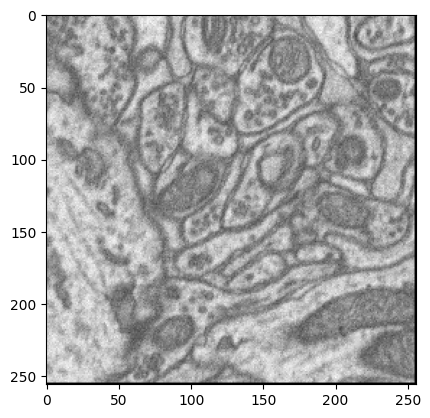

In [ ]:
plt.imshow(images[0], cmap='gray')
plt.show()

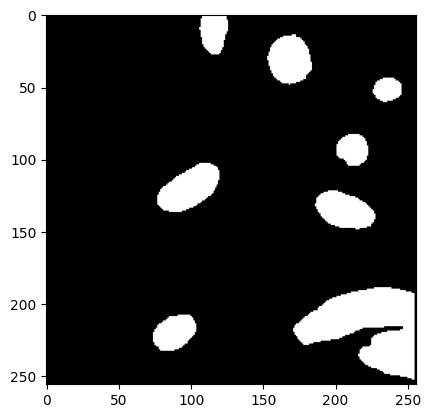

In [ ]:
# TODO: Show the first mask.
plt.imshow(masks[0], cmap='gray')
plt.show()

## 1. SAM in AUTO mode (15 points)

In [ ]:
# We will use the METASEG package as an easy-to-use layer
# for SAM.
!pip install metaseg==0.6.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# SAM comes in two modes, auto and with seeds
from metaseg import SegAutoMaskPredictor, SegManualMaskPredictor

In [ ]:
# SAM takes files as input!
# So we have to store the numpy array to disk.
mh.imsave('first.png', images[0])

In [ ]:
#
# Run SAM in auto mode on first.png and store
# the result as first_output.png.
#
results = SegAutoMaskPredictor().image_predict(
    source="first.png",
    model_type="vit_l", # vit_l, vit_h, vit_b
    points_per_side=16, 
    points_per_batch=64,
    min_area=0,
    output_path="first_output.png",
    show=False,
    save=True,
)

vit_l model already exists as 'vit_l.pth'. Skipping download.


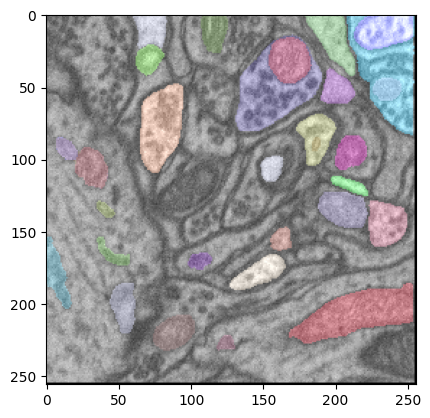

In [ ]:
imshow( mh.imread('first_output.png') )

In [ ]:
# TODO: Does SAM work well for mitochondria detection?
# TODO: YOUR_ANSWER
# Yes it is working good.

In [ ]:
# TODO: Try the auto predictor on your image!
# 
# Please upload your own image and test how well
# the auto mode of SAM performs!
#
# Run SAM in auto mode on that image and store
# the result as second_output.png. Show the output!
#

In [ ]:
# TODO: YOUR CODE
results = SegAutoMaskPredictor().image_predict(
    source="1.png",
    model_type="vit_l", # vit_l, vit_h, vit_b
    points_per_side=16, 
    points_per_batch=64,
    min_area=0,
    output_path="2.png",
    show=False,
    save=True,
)

vit_l model already exists as 'vit_l.pth'. Skipping download.


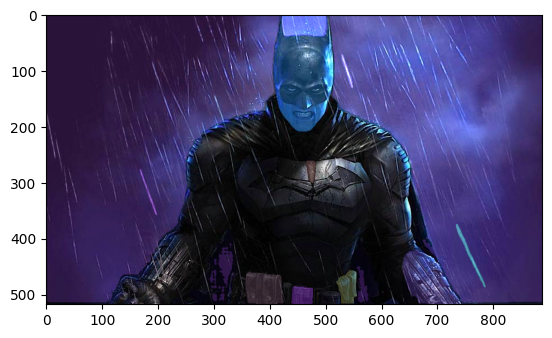

In [ ]:
# TODO: Does SAM work well on your example?
# TODO: YOUR_ANSWER
imshow( mh.imread('2.png') )

## 2. Train a U-Net classifier from scratch (50 points)


In [ ]:
# We will use the keras_unet package!
#
# HINT: There is documentation available here, if you are stuck during this part
# of the assignment: https://github.com/karolzak/keras-unet
!pip install keras_unet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# keras_unet has convenience functions to visualize data
from keras_unet.utils import plot_imgs

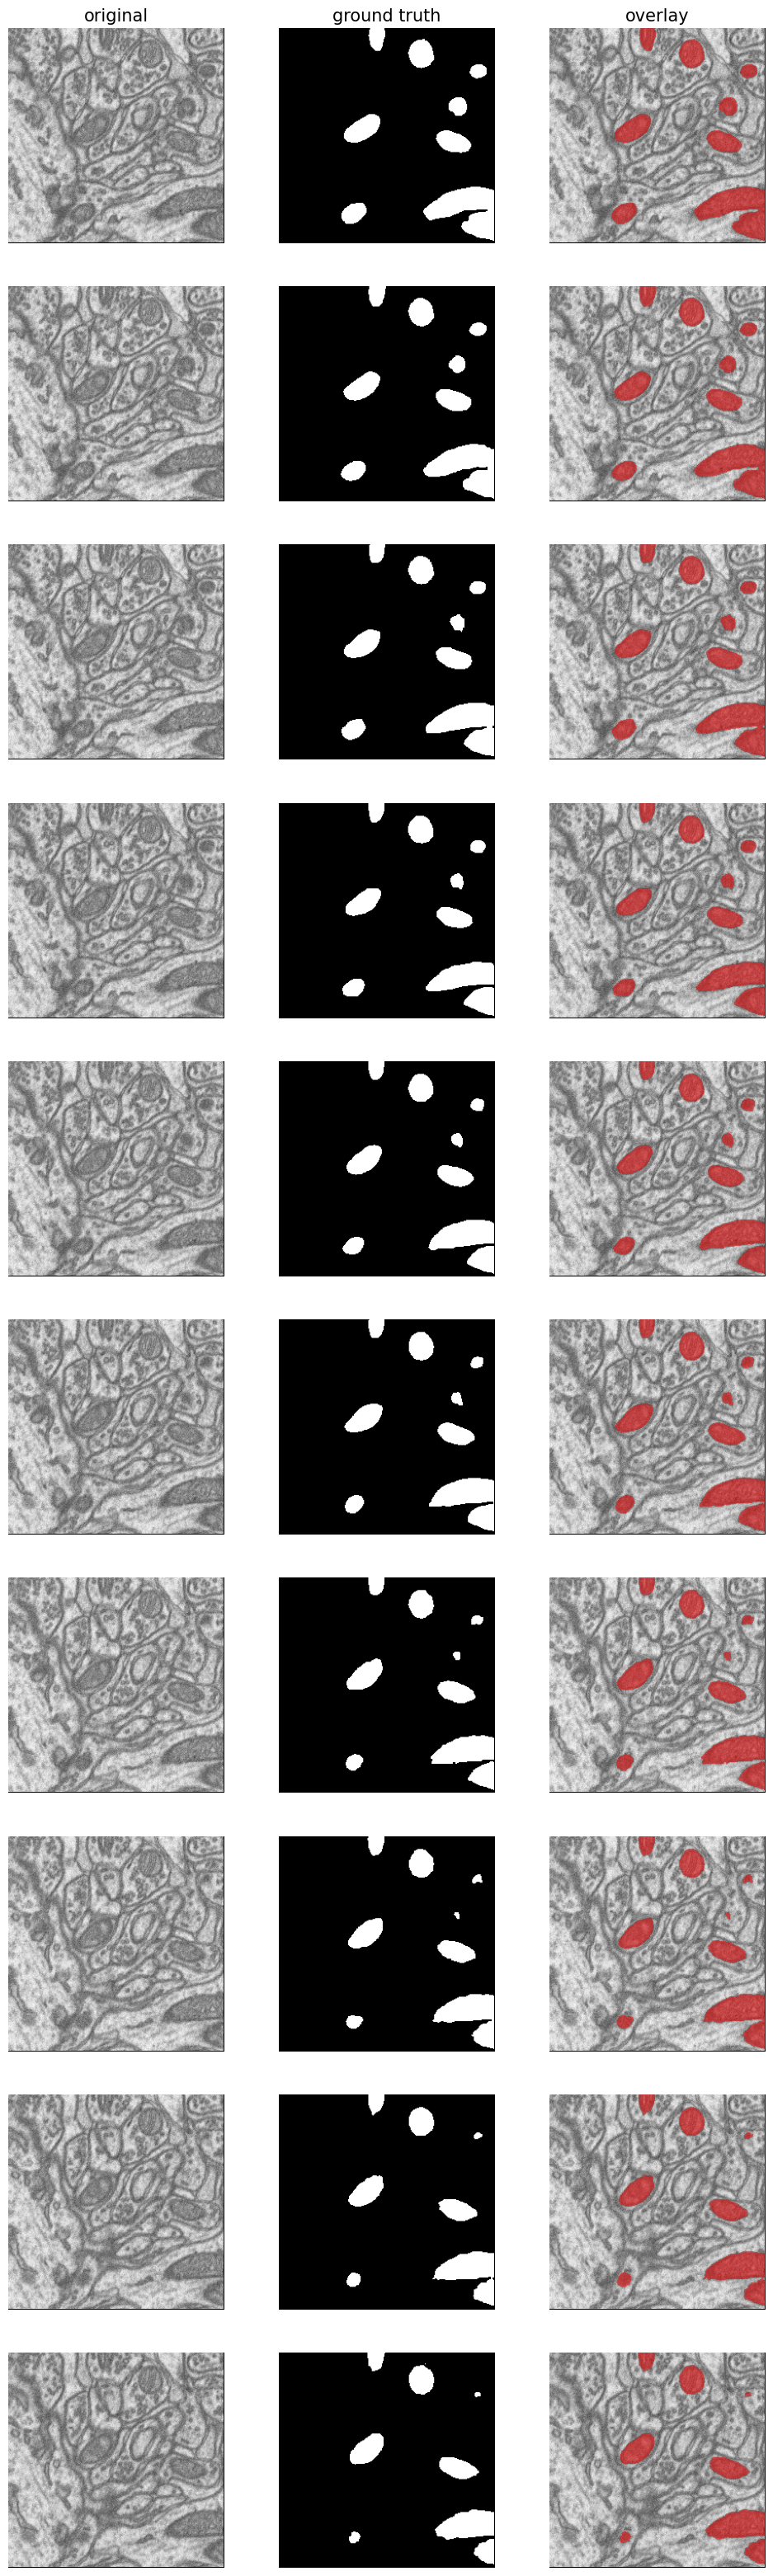

In [ ]:
# Let's plot a few images and masks.
plot_imgs(org_imgs=images, mask_imgs=masks)

In [ ]:
# The images are in this format.
print( images.shape, images.max(), images.dtype )

(660, 256, 256) 243 uint8


In [ ]:
# TODO convert the format to the following:
# (660, 256, 256, 1) 1.0 float32
#
# 1) convert to float32
# 2) normalize to the range of 0..1
# 3) Add the last channel using .reshape like in class
#
# TODO: YOUR_CODE
# X = 
X = images.astype(np.float32)
X = (X - X.min()) / (X.max() - X.min())
X = X.reshape(*X.shape, 1)

In [ ]:
# Validate that everything matches accordingly
print( X.shape, X.max(), X.dtype )

(660, 256, 256, 1) 1.0 float32


In [ ]:
# The masks are in this format.
print( masks.shape, masks.max(), masks.dtype )

(660, 256, 256) 255 uint8


In [ ]:
# TODO convert the format to the following:
# (660, 256, 256, 1) True bool
#
# 1) convert to bool
# 2) Add the last channel using .reshape like in class
#
# TODO: YOUR_CODE
# y = 
y = masks.astype(bool)
y = y.reshape(*y.shape, 1)

In [ ]:
# Validate that everything matches accordingly
print( y.shape, y.max(), y.dtype )

(660, 256, 256, 1) True bool


In [ ]:
#
# Now we will create our train/val/test splits using scikit-learn!
#
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=0)

In [ ]:
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_val: ", X_val.shape)
print("y_val: ", y_val.shape)
print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)

X_train:  (369, 256, 256, 1)
y_train:  (369, 256, 256, 1)
X_val:  (159, 256, 256, 1)
y_val:  (159, 256, 256, 1)
X_test:  (132, 256, 256, 1)
y_test:  (132, 256, 256, 1)


In [ ]:
# TODO: Why do we call train_test_split twice?
# TODO: YOUR_ANSWER
"""In order to have more training data than testing and validation data, we utilized two different calls. During the first call, we designated the dataset as testing data and during the second call, we designated it as validation data. This allowed us to increase the amount of training data available for our purposes."""

'In order to have more training data than testing and validation data, we utilized two different calls. During the first call, we designated the dataset as testing data and during the second call, we designated it as validation data. This allowed us to increase the amount of training data available for our purposes.'

In [ ]:
#
# We will use keras_unet's built-in data augmentation
# functionality.
#
from keras_unet.utils import get_augmented

train_gen = get_augmented(
    X_train, y_train, batch_size=2,
    data_gen_args = dict(
        rotation_range=15.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=50,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    ))

In [ ]:
# TODO: Please explain the code from above.
# TODO: YOUR_ANSWER

"""The function get_augmented is utilized to produce additional image data with various transformations to train a machine learning model. It requires the training data X_train and their corresponding labels y_train, as well as a batch size of 2 and a dictionary containing data augmentation arguments. These arguments determine the extent of random modifications that can be applied to the images to expand the training data. For example, rotation_range=15. specifies that the images can be rotated randomly by up to 15 degrees, while width_shift_range and height_shift_range determine the range of horizontal and vertical shifts. The shear_range, zoom_range, horizontal_flip, and vertical_flip parameters control the range of random shearing, zooming, and flipping of the images. Finally, fill_mode='constant' indicates how to fill the empty pixels produced by these transformations."""

"The function get_augmented is utilized to produce additional image data with various transformations to train a machine learning model. It requires the training data X_train and their corresponding labels y_train, as well as a batch size of 2 and a dictionary containing data augmentation arguments. These arguments determine the extent of random modifications that can be applied to the images to expand the training data. For example, rotation_range=15. specifies that the images can be rotated randomly by up to 15 degrees, while width_shift_range and height_shift_range determine the range of horizontal and vertical shifts. The shear_range, zoom_range, horizontal_flip, and vertical_flip parameters control the range of random shearing, zooming, and flipping of the images. Finally, fill_mode='constant' indicates how to fill the empty pixels produced by these transformations."

(2, 256, 256, 1) (2, 256, 256, 1)


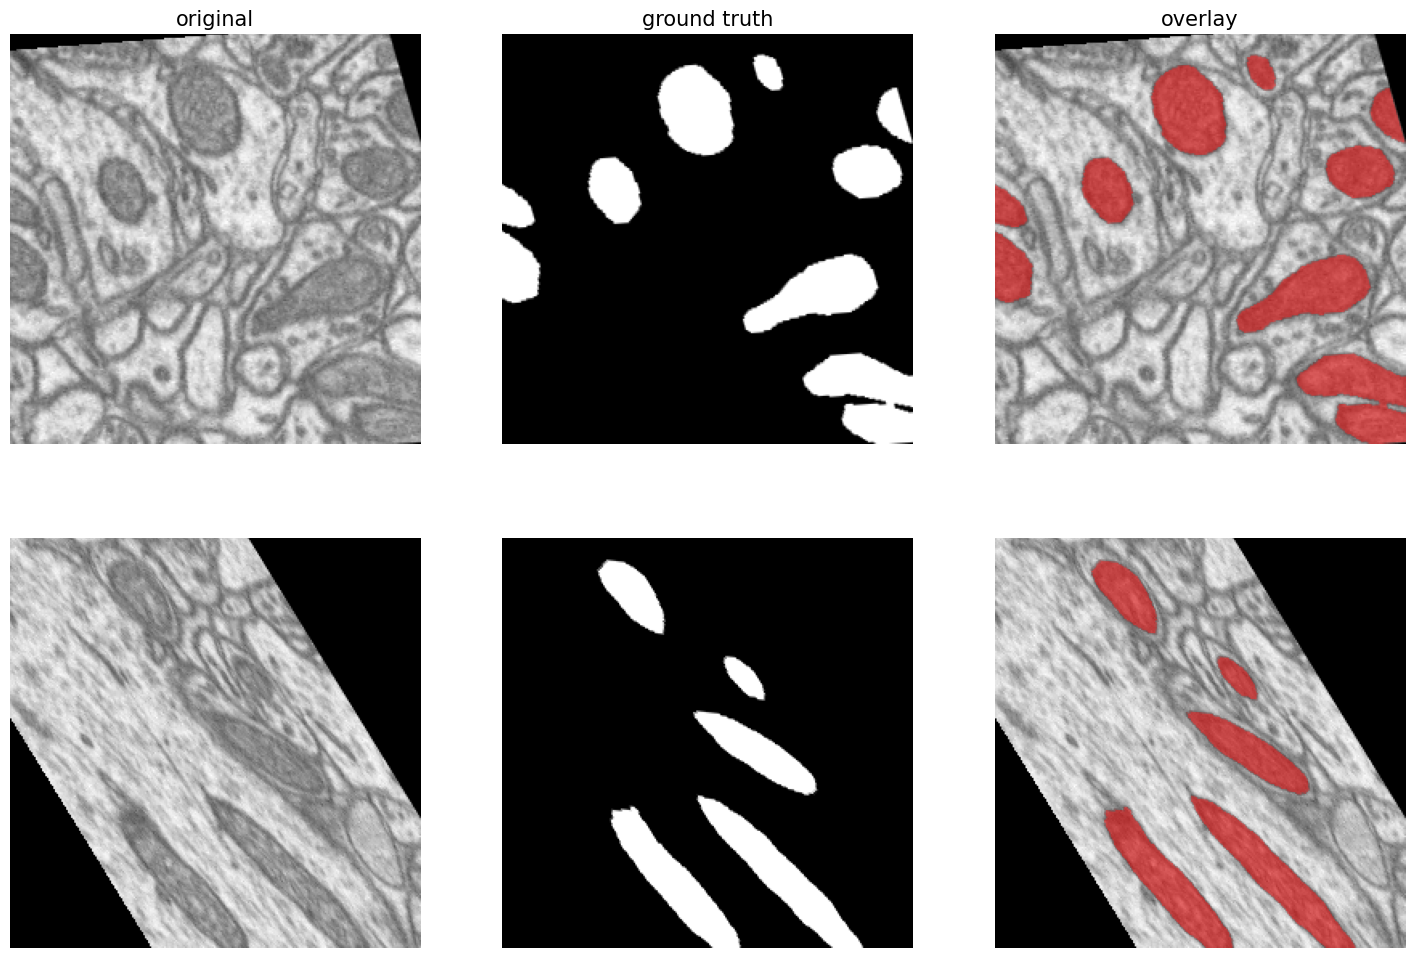

In [ ]:
# Run the following code to visualize augmented examples.
sample_batch = next(train_gen)
xx, yy = sample_batch
print(xx.shape, yy.shape)
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=xx, mask_imgs=yy, nm_img_to_plot=2, figsize=6)

In [ ]:
#
# Now, we set up a U-Net classifier.
#
from keras_unet.models import custom_unet

model = custom_unet(
    X_train[0].shape,
    use_batch_norm=False,
    num_classes=1,
    filters=64,
    dropout=0.2,
    output_activation='sigmoid'
)

In [ ]:
# TODO: How many  trainable parameters does the model use?
# TODO: YOUR_ANSWER
print (model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 64  640         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 spatial_dropout2d_5 (SpatialDr  (None, 256, 256, 64  0          ['conv2d_19[0][0]']              
 opout2D)                       )                                                           

In [ ]:
#
# Let's compile the model. Please use a LEARNING_RATE of 0.01
# and a MOMENTUM of 0.99.
#
LEARNING_RATE = 0.01
MOMENTUM = 0.99

In [ ]:
#
# We will use Stochastic Gradient Descent as optimizer
# and use IoU as a metric.
#
from keras.optimizers import SGD
from keras_unet.metrics import iou, iou_thresholded

model.compile(
    optimizer=SGD(learning_rate=LEARNING_RATE, momentum=MOMENTUM),
    loss='binary_crossentropy',
    metrics=[iou, iou_thresholded]
)

In [ ]:
# TODO: Please explain Intersect-over-Union (IoU) in just a few sentences.
# TODO: YOUR_ANSWER

"""The Intersection-over-Union (IoU) metric is widely utilized to assess the similarity between two bounding boxes. It is obtained by dividing the area of intersection between the two boxes by the area of their union. A greater IoU value indicates that the two boxes have a larger overlap and are more similar."""

'The Intersection-over-Union (IoU) metric is widely utilized to assess the similarity between two bounding boxes. It is obtained by dividing the area of intersection between the two boxes by the area of their union. A greater IoU value indicates that the two boxes have a larger overlap and are more similar.'

In [ ]:
#
# Now let's train the model for 30 epochs!
#
# TODO: Please complete the code below.
# Hint: Don't forget to use the train_gen from above as training data.
# Hint 2: Please don't forget (X_val, y_val) as validation data.
# Hint 3: steps_per_epoch should be set to all of the X_train.
# Hint 4: This will take roughly 30 minutes.
# Hint 5: If you are stuck, look through the repo of keras_unet!
#
history = model.fit(
                    train_gen,
                    steps_per_epoch=len(X_train) // 2,
                    epochs=30,
                    validation_data=(X_val, y_val)                    
)

Epoch 1/30
184/184 [==============================] - 6s 23ms/step - loss: 0.2511 - iou: 0.0454 - iou_thresholded: 2.4888e-04 - val_loss: 0.2493 - val_iou: 0.0787 - val_iou_thresholded: 6.0699e-06
Epoch 2/30
184/184 [==============================] - 4s 20ms/step - loss: 0.1886 - iou: 0.0967 - iou_thresholded: 1.4428e-04 - val_loss: 0.2091 - val_iou: 0.1136 - val_iou_thresholded: 6.0699e-06
Epoch 3/30
184/184 [==============================] - 4s 20ms/step - loss: 0.1689 - iou: 0.1378 - iou_thresholded: 1.6686e-04 - val_loss: 0.2072 - val_iou: 0.1206 - val_iou_thresholded: 6.0699e-06
Epoch 4/30
184/184 [==============================] - 4s 20ms/step - loss: 0.1736 - iou: 0.1389 - iou_thresholded: 0.0253 - val_loss: 0.2025 - val_iou: 0.1079 - val_iou_thresholded: 6.0699e-06
Epoch 5/30
184/184 [==============================] - 4s 20ms/step - loss: 0.1820 - iou: 0.1126 - iou_thresholded: 0.0232 - val_loss: 0.2459 - val_iou: 0.0635 - val_iou_thresholded: 6.0699e-06
Epoch 6/30
184/184 [===

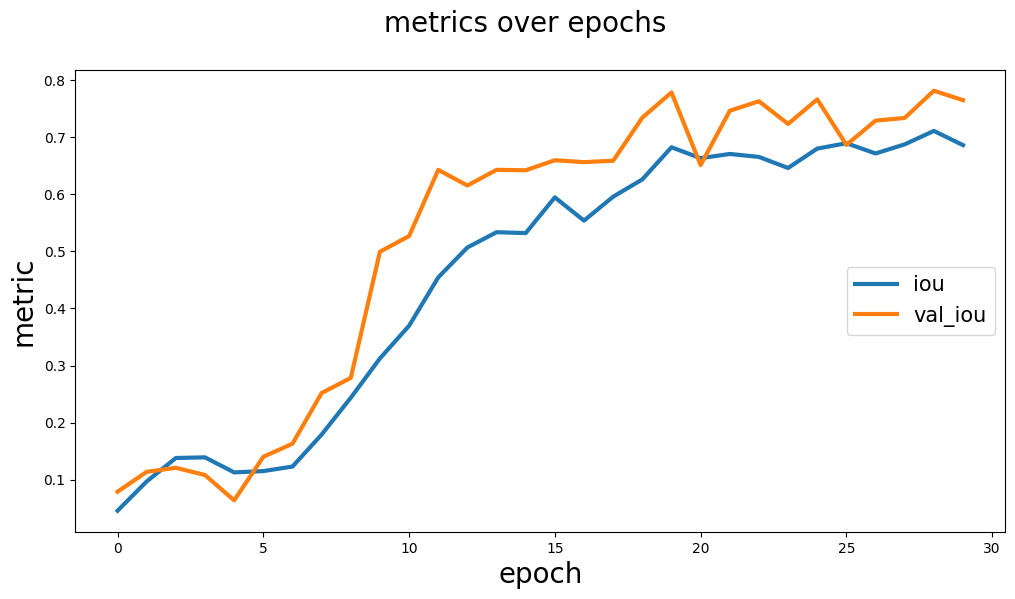

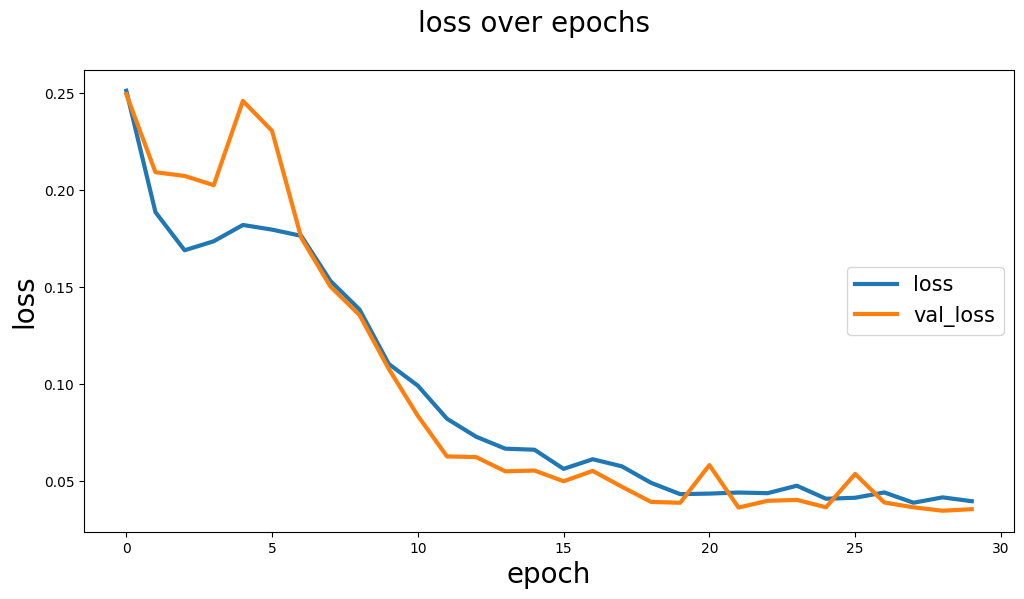

In [ ]:
# We can use keras_unet functionality to visualize metrics and loss during training.
from keras_unet.utils import plot_segm_history

plot_segm_history(history)

In [ ]:
# TODO: Do these plots look good to you?
# TODO: YOUR_ANSWER

"""Yes, the plots are good."""

'Yes, the plots are good.'

## 3. Evaluate U-Net (10 points)

In [ ]:
# Let's predict all of X_test
y_pred = model.predict(X_test)

5/5 [==============================] - 0s 53ms/step


In [ ]:
# ...and look at some results.
plot_imgs(org_imgs=X_test, mask_imgs=y_test, pred_imgs=y_pred, nm_img_to_plot=9)

NameError: ignored

In [ ]:
import sklearn.metrics

In [ ]:
# Let's use the Jaccard score to compare a thresholded
# y_pred to the groundtruth y_test.
sklearn.metrics.jaccard_score(y_test.ravel(), (y_pred > 0.5).ravel())

0.8419175769966836

In [ ]:
# TODO: What is the difference between Jaccard Score and Intersect-over-Union from above?
# TODO: YOUR_ANSWER 
"""The Jaccard score and IoU are equivalent measures that are used to evaluate the similarity between two sets, or in the case of object detection, the similarity between two bounding boxes. Both metrics calculate the ratio of the size of the intersection between two sets (or boxes) to the size of their union."""

'The Jaccard score and IoU are equivalent measures that are used to evaluate the similarity between two sets, or in the case of object detection, the similarity between two bounding boxes. Both metrics calculate the ratio of the size of the intersection between two sets (or boxes) to the size of their union.'

In [ ]:
# TODO: Did the U-Net perform well on X_test?
# TODO: YOUR_ANSWER

"""Yes"""

'Yes'

## 4. Combine U-Net with SAM (10 points)

In [ ]:
# Instead of running SAM in auto mode without seeds (Task 1), we will now
# use the U-Net predictions on X_test to seed the SAM model.

In [ ]:
# We can use the following convenience functions
# to 1) convert mahotas bounding boxes to SAM format
# and 2) combine the SAM output tensors to a mask.

In [ ]:
def mahotas_bbox_to_sam(bbs):

  new_bbs = []

  for i,bb in enumerate(bbs):
    # from (y1, y2, x1, x2)
    # to (x1, y1, x2, y2)
    if i == 0:
      continue
    new_bb = [bb[2], bb[0], bb[3], bb[1]]
    new_bbs.append(new_bb)

  return new_bbs

In [ ]:
def sam_to_mask(results):

  results = results.cpu() # copy back to cpu land

  mask = np.array(results[0,0])

  for s in results:
    mask[s[0] == 1] = 1

  return mask

In [ ]:
# The following code combines the U-Net predictions with SAM.
#
# TODO: Please study the code and answer the TODOs in-line.

In [ ]:
y_pred_sam = y_pred.copy()
y_pred_sam[:] = 0

for z,img in enumerate(X_test):

  # TODO: EXPLAIN CODE BELOW
  mh.imsave('test.png', (img[:,:,0]*255).astype(np.uint8))
  #saves an image as test.png it also creates the scaling of values from 0-255


  # TODO: EXPLAIN CODE BELOW
  pred = (y_pred[z] > 0.5)
  #connected component labeling to the binary mask 'pred'


  # TODO: EXPLAIN CODE BELOW
  pred, _ = mh.labeled.label(pred)
   #Here the thereshold values are being modified,

  # TODO: EXPLAIN CODE BELOW
  bbs = mh.labeled.bbox(pred)
  #calculates the bounding boxes of each connected component in the label matrix pred. 



  # TODO: EXPLAIN CODE BELOW
  bbs_converted = mahotas_bbox_to_sam(bbs)
  #converts the bounding box coordinates from the format used by the Mahotas library

  # TODO: EXPLAIN CODE BELOW
  results = SegManualMaskPredictor().image_predict(
      source="test.png",
      model_type="vit_l", # vit_l, vit_h, vit_b
      input_box=bbs_converted, 
      multimask_output=False,
      random_color=False,
      show=False,
      save=False,
  )
  ##Here we are runnin the sam in manual prediction, with no random colors and model type vit_l 


  # TODO: EXPLAIN CODE BELOW
  sam_and_unet_pred = sam_to_mask(results)
  #converts the segmentation masks returned by the SAM tool (results)

  # TODO: EXPLAIN CODE BELOW
  y_pred_sam[z,:,:,0] = sam_and_unet_pred
  # updates the predicted output y_pred_sam at slice z with the segmentation masks predicted by the SAM tool 


vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l mo

## 5. Compare U-Net vs. U-Net+SAM. (10 points)

In [ ]:
# U-Net performance on X_test (from Task 3)
sklearn.metrics.jaccard_score(y_test.ravel(), (y_pred > 0.5).ravel())

0.8419175769966836

In [ ]:
# U-Net + SAM performance on X_test
sklearn.metrics.jaccard_score(y_test.ravel(), y_pred_sam.ravel())

0.8344435793595919

In [ ]:
# TODO: Please explain the results - is U-Net+SAM a good addition?
# TODO: YOUR_ANSWER
"""U-net performs better compared to the SAM + UNET"""

## Bonus: Improve the results. (33 points)

In [ ]:
# Please improve the results of U-Net+SAM and show the improved Jaccard score.

In [ ]:
# TODO: YOUR_CODE
y_pred_sam = y_pred.copy()
y_pred_sam[:] = 0

for z,img in enumerate(X_test):

  # TODO: EXPLAIN CODE BELOW
  mh.imsave('test.png', (img[:,:,0]*255).astype(np.uint8))
  #saves an image as test.png it also creates the scaling of values from 0-255


  # TODO: EXPLAIN CODE BELOW
  pred = (y_pred[z] > 0.6)
  #connected component labeling to the binary mask 'pred'


  # TODO: EXPLAIN CODE BELOW
  pred, _ = mh.labeled.label(pred)
   #Here the thereshold values are being modified,

  # TODO: EXPLAIN CODE BELOW
  bbs = mh.labeled.bbox(pred)
  #calculates the bounding boxes of each connected component in the label matrix pred. 



  # TODO: EXPLAIN CODE BELOW
  bbs_converted = mahotas_bbox_to_sam(bbs)
  #converts the bounding box coordinates from the format used by the Mahotas library

  # TODO: EXPLAIN CODE BELOW
  results = SegManualMaskPredictor().image_predict(
      source="test.png",
      model_type="vit_l", # vit_l, vit_h, vit_b
      input_box=bbs_converted, 
      multimask_output=False,
      random_color=False,
      show=False,
      save=False,
  )
  ##Here we are runnin the sam in manual prediction, with no random colors and model type vit_l 


  # TODO: EXPLAIN CODE BELOW
  sam_and_unet_pred = sam_to_mask(results)
  #converts the segmentation masks returned by the SAM tool (results)

  # TODO: EXPLAIN CODE BELOW
  y_pred_sam[z,:,:,0] = sam_and_unet_pred
  # updates the predicted output y_pred_sam at slice z with the segmentation masks predicted by the SAM tool 


vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l mo

In [ ]:
sklearn.metrics.jaccard_score(y_test.ravel(), (y_pred > 0.7).ravel())

0.8375329560022253

In [ ]:
sklearn.metrics.jaccard_score(y_test.ravel(), y_pred_sam.ravel())

0.8408011177017037

In [ ]:
"""The imporvement is noticeable"""

In [ ]:
#In colab with Sruthi Chirumamilla

In [ ]:
#
# You made it!!
#
#                 _ ___                /^^\ /^\  /^^\_
#     _          _@)@) \            ,,/ '` ~ `'~~ ', `\.
#   _/o\_ _ _ _/~`.`...'~\        ./~~..,'`','',.,' '  ~:
#  / `,'.~,~.~  .   , . , ~|,   ,/ .,' , ,. .. ,,.   `,  ~\_
# ( ' _' _ '_` _  '  .    , `\_/ .' ..' '  `  `   `..  `,   \_
#  ~V~ V~ V~ V~ ~\ `   ' .  '    , ' .,.,''`.,.''`.,.``. ',   \_
#   _/\ /\ /\ /\_/, . ' ,   `_/~\_ .' .,. ,, , _/~\_ `. `. '.,  \_
#  < ~ ~ '~`'~'`, .,  .   `_: ::: \_ '      `_/ ::: \_ `.,' . ',  \_
#   \ ' `_  '`_    _    ',/ _::_::_ \ _    _/ _::_::_ \   `.,'.,`., \-,-,-,_,_,
#    `'~~ `'~~ `'~~ `'~~  \(_)(_)(_)/  `~~' \(_)(_)(_)/ ~'`\_.._,._,'_;_;_;_;_;
#